In [118]:
import torch
import torch.linalg as LA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from sklearn.cluster import KMeans
import re
from tqdm import tqdm
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_ITER = 10000

In [260]:
class Quantizer:
    def __init__(self, Q1='random', Q2='random', eps=6e-6):
        self.eps = eps
        self.Q1 = Q1
        self.Q2 = Q2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.N_CLUSTERS = 24
        
    def get_random_orthogonal(self, N, M, dtype=torch.float32, kind='normal'):
        if kind == 'normal':
            matrix = torch.randn(N, M).to(dtype).to(device)
            Q1, _ = LA.qr(matrix)
            matrix = torch.randn(M, N).to(dtype).to(device)
            Q2, _ = LA.qr(matrix)
            return Q1, Q2 
        
    def decompose_matrix(self, X_arg):
        X = X_arg.clone()
        dtype = X.dtype 
        U = torch.zeros_like(X).to(dtype).to(self.device)
        Vh = torch.zeros_like(X).to(dtype).to(self.device)
        Q1, Q2 = self.get_random_orthogonal(X.shape[0], X.shape[1], X.dtype)
        X0 = X.clone()
        proj = lambda X, Y: X.view(-1).T @ Y.view(-1) / torch.norm(Y) ** 2 * Y
        num_iter = 0 
        while (torch.norm(X0 - U - Vh) >= self.eps) and (num_iter < MAX_ITER):
            Y = Q1.T @ X @ Q2
            if torch.sum(torch.abs(X)) > torch.sum(torch.abs(Y)):
                pi = proj(X, torch.sign(X))
                U += pi
            else:
                pi = proj(X, Q1 @ torch.sign(Y) @ Q2.T)
                Vh += pi 
            X -= pi
            num_iter += 1
        
        if num_iter == MAX_ITER:
            return X, X, torch.zeros_like(X).to(dtype).to(self.device), Q1, Q2
        else:
            return U, Vh, Q1.T @ Vh @ Q2, Q1, Q2
    
    def quantize_UV(self, U, V):
        u = U.clone().flatten()
        v = V.clone().flatten()

        kmeans_u = KMeans(n_clusters=self.N_CLUSTERS, random_state=0, n_init="auto").fit(u.view(-1,1).cpu())
        kmeans_v = KMeans(n_clusters=self.N_CLUSTERS, random_state=0, n_init="auto").fit(v.view(-1,1).cpu())
        
        for cluster in np.unique(kmeans_u.labels_):
            inds = np.where(kmeans_u.labels_ == cluster)[0]
            mean = torch.mean(u[inds])
            u[inds] = mean
        for cluster in np.unique(kmeans_v.labels_):
            inds = np.where(kmeans_v.labels_ == cluster)[0]
            mean = torch.mean(v[inds])
            v[inds] = mean
        return u, v, torch.from_numpy(kmeans_u.labels_), torch.from_numpy(kmeans_v.labels_)
    
    def decompose_v(x, Q,):
        self.device = X.device
        x = x.double()
        x0 = x.clone()
        Q = Q.double()
        u = torch.zeros_like(x).to(device).double()
        v = torch.zeros_like(x).to(device).double()
        proj = lambda x, y: x.T @ y / (torch.norm(y) ** 2) * y

        while torch.norm(x0 - u - v) >= eps:
            if torch.sum(torch.abs(x)) > torch.sum(torch.abs(Q.T @ x)):
                pi = proj(x, torch.sign(x))
                u += pi
            else:
                pi = proj(x, Q @ torch.sign (Q.T @ x))
                v += pi
            x -= pi
        return u, v

In [232]:
def plot_UV(u, v, centroids=None, labels=None):
    if centroids is None:
        sns.scatterplot(x=u.flatten().cpu(), y=v.flatten().cpu()).set(xlabel='U entries', ylabel='V entries')
    elif labels is None:
        sns.scatterplot(x=u.flatten().cpu(), y=v.flatten().cpu(),label='entries').set(xlabel='U entries', ylabel='V entries', title='Scatterplot of U and V entries')
        U, V = centroids
        sns.scatterplot(x=U.flatten().cpu(), y=V.flatten().cpu(), color='red', label='centroids').set(xlabel='U', ylabel='V', title='Scatterplot of U and V entries')
    else:
        U, V = centroids
        lu, lv = labels
        labels_all = lu * len(torch.unique(lu)) + lv
        sns.scatterplot(x=u.flatten().cpu(), y=v.flatten().cpu(), hue=labels_all, legend=False, palette='Spectral').set(xlabel='U entries', ylabel='V entries', title='Scatterplot of U and V entries')
        sns.scatterplot(x=U.flatten().cpu(), y=V.flatten().cpu(), color='red').set(xlabel='U entries', ylabel='V entries')
        plt.show()
        

def plot_hist(X, U, V): 
    fig, ax = plt.subplots(1, 3, figsize=(10,6))

    sns.histplot(U.flatten().cpu(), discrete=False, ax=ax[0]).set(title='U')
    sns.histplot(V.flatten().cpu(), discrete=False, ax=ax[1]).set(title='V')
    sns.histplot(X.flatten().cpu(), discrete=False, ax=ax[2]).set(title='X')
    
    plt.show()

In [ ]:
N1 = 768
N2 = 768

M = torch.randn(N1, N2).double().to(device)
Q1, _ = LA.qr(M)
M = torch.randn(N2, N1).double().to(device)
Q2, _ = LA.qr(M)

X = torch.randn(N1, N2).double().to(device)

In [261]:
X = torch.tensor(model.distilbert.transformer.layer[1].ffn.lin1.weight)

/tmp/ipykernel_1649153/1552190417.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(model.distilbert.transformer.layer[1].ffn.lin1.weight)


In [219]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


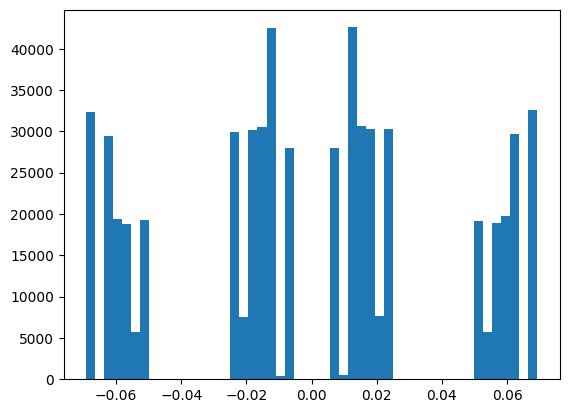

In [180]:
plt.hist(V.flatten().cpu(), bins=50)
plt.show()

In [262]:
quant = Quantizer()
X = torch.tensor(model.distilbert.transformer.layer[4].attention.v_lin.weight).detach().clone()
U, Vh, V, Q1, Q2 = quant.decompose_matrix(X)
u, v, lu, lv = quant.quantize_UV(U, V)


/tmp/ipykernel_1649153/1639175094.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(model.distilbert.transformer.layer[4].attention.v_lin.weight).detach().clone()


In [263]:
torch.norm(X - U - Vh)

tensor(5.5416e-06, device='cuda:0')

In [264]:
torch.norm(X)

tensor(36.0239, device='cuda:0')

In [266]:
u = u.reshape_as(X)
v = v.reshape_as(X)
torch.norm(U - u)

tensor(0.1922, device='cuda:0')

In [267]:

torch.norm(X - u - Q1 @ v @ Q2.T)

tensor(0.5225, device='cuda:0')

In [189]:
torch.norm(U)

tensor(11.6423, device='cuda:0')

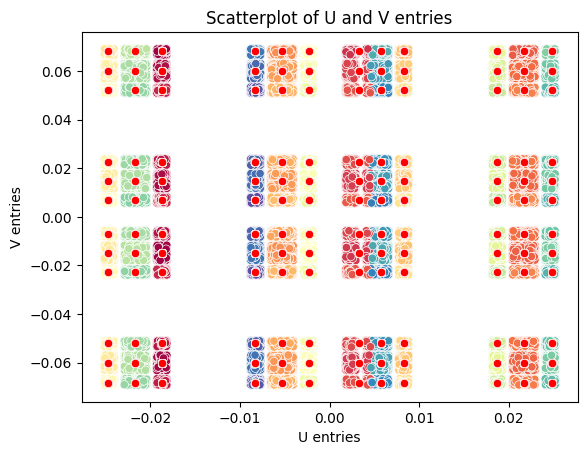

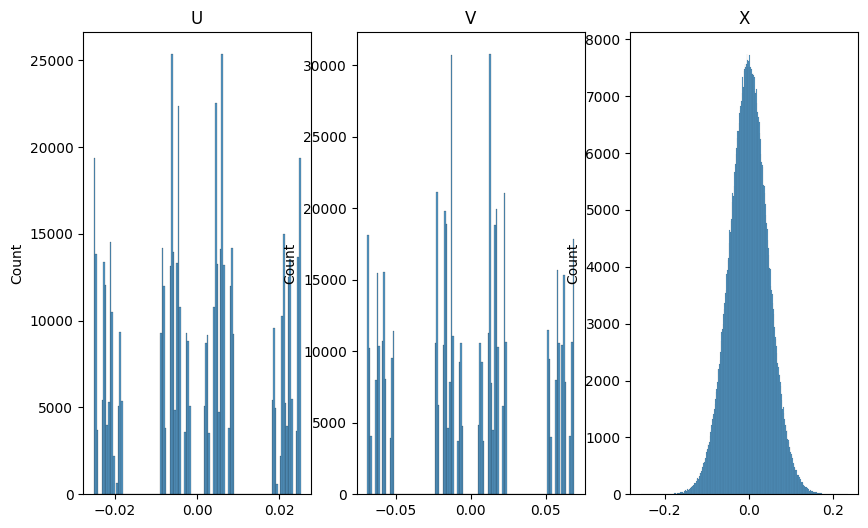

In [234]:
plot_UV(U, V, (u, v), (lu, lv))
plot_hist(X, U, V)

In [176]:
torch.norm(X - U - Vh)

tensor(36.0280, device='cuda:0')

In [174]:
X - U - Vh

tensor([[ 0.0531, -0.0294, -0.0275,  ..., -0.0427, -0.0238, -0.1225],
        [ 0.0370, -0.0052,  0.0593,  ..., -0.0355, -0.0217, -0.0336],
        [-0.0079,  0.0431, -0.0132,  ..., -0.0244,  0.0189,  0.0433],
        ...,
        [ 0.0280, -0.0618,  0.0662,  ..., -0.0921,  0.0116, -0.0414],
        [-0.0319, -0.0554,  0.0157,  ...,  0.0381,  0.0024,  0.0587],
        [-0.0237, -0.0557,  0.0490,  ..., -0.0350,  0.0241, -0.0076]],
       device='cuda:0')

In [129]:
model = transformers.AutoModel.from_pretrained("distilbert-base-uncased", device_map=device)

/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [57]:
linear_names = []
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Linear):
        #name1 = re.sub(r'(\d+)', r'[\1]', str(name).replace('[', '.['))
        #linear_names.append(name1.replace('[', '.[').replace('..', '.'))
        linear_names.append(re.sub(r'.(\d+).', r'.[\1].', str(name).replace('[', '.[')))
        #linear_names.append(name)

/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|███████████████████████████████████████████| 36/36 [00:31<00:00,  1.15it/s]

Successful: 23/36, 0.64\%


In [131]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding


imdb = load_dataset("imdb")
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
 
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

import numpy as np
from datasets import load_metric
 


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   #f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy}

In [253]:
from transformers import TrainingArguments, Trainer
 
repo_name = "finetuning-sentiment-model-3000-samples"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=10,
   weight_decay=0.01,
   save_strategy="epoch",
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
Detected kernel version 5.4.265, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [254]:
trainer.train()

Step,Training Loss
500,0.250400
1000,0.049200
1500,0.016100


TrainOutput(global_step=1880, training_loss=0.08613302885217869, metrics={'train_runtime': 520.2135, 'train_samples_per_second': 57.669, 'train_steps_per_second': 3.614, 'total_flos': 3929506704322272.0, 'train_loss': 0.08613302885217869, 'epoch': 10.0})

In [256]:
trainer.predict(tokenized_test)[2]

{'test_loss': 0.6489244103431702,
 'test_accuracy': 0.8833333333333333,
 'test_runtime': 3.3429,
 'test_samples_per_second': 89.744,
 'test_steps_per_second': 5.684}

In [259]:
trainer_quantized.predict(tokenized_test)[2]

{'test_loss': 0.6936922073364258,
 'test_accuracy': 0.5,
 'test_runtime': 3.2428,
 'test_samples_per_second': 92.512,
 'test_steps_per_second': 5.859}

In [247]:
from transformers import TrainingArguments, Trainer
 
repo_name = "finetuning-sentiment-model-3000-samples"
 
training_args_quantized = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
)
 
trainer_quantized = Trainer(
   model=model_quantized,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

/beegfs/home/andrey.gladkov/environments/nlp/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
Detected kernel version 5.4.265, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [268]:
import copy

model_quantized = copy.deepcopy(model)

In [ ]:
quant = Quantizer()
#model = transformers.AutoModel.from_pretrained("distilbert-base-uncased", device_map=device)

linear_names = []
for name, layer in model_quantized.named_modules():
    if isinstance(layer, torch.nn.Linear):
        linear_names.append(re.sub(r'.(\d+).', r'.[\1].', str(name).replace('[', '.[')))
        
#print(linear_names)
failed = 0
for linear_name in tqdm(linear_names):
    obj = model_quantized
    for attr in linear_name.split('.'):
        if attr[0] != '[':
            obj = getattr(obj, attr)
        else:
            obj = obj.__getitem__(int(attr[1:-1]))
    with torch.no_grad():
        U, Vh, V, Q1, Q2 = quant.decompose_matrix(obj.weight)
        if np.isclose(torch.norm(V).cpu(), 0.0):
            failed += 1
            continue
        u, v, _, _ = quant.quantize_UV(U, V)
        N, M = obj.weight.shape
        u = u.view(N, M)
        vh = Q1 @ v.view(N, M) @ Q2.T
        
        
        obj.weight = nn.Parameter((u + vh).view(N, M))
        
print(f'Successful: {len(linear_names) - failed}/{len(linear_names)}, {(len(linear_names) - failed) / len(linear_names) * 100:.1f}%')

 11%|██████████████████▍                                                                                                                                                            | 4/38 [00:09<01:36,  2.82s/it]